#### Импорт библиотек

In [237]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime
import random
pd.options.mode.chained_assignment = None

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Загрузка данных

In [3]:
train_data = pd.read_csv('/Users/daria/code/gb/01/python_libraries/final_project/real-estate-price-prediction-moscow/train.csv')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [4]:
train_data.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [5]:
test_data = pd.read_csv('/Users/daria/code/gb/01/python_libraries/final_project/real-estate-price-prediction-moscow/test.csv')
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [6]:
train_data.shape, test_data.shape

((10000, 20), (5000, 19))

В тестовых данных отсутствует один столбец - цена, целевой признак

In [7]:
train_data['Id'] = train_data['Id'].astype(str)
train_data['DistrictId'] = train_data['DistrictId'].astype(str)

#### Анализ и предобработка первичных данных

##### Анализ данных

__Целевая переменная Price__, построим гистограмму ее распределения

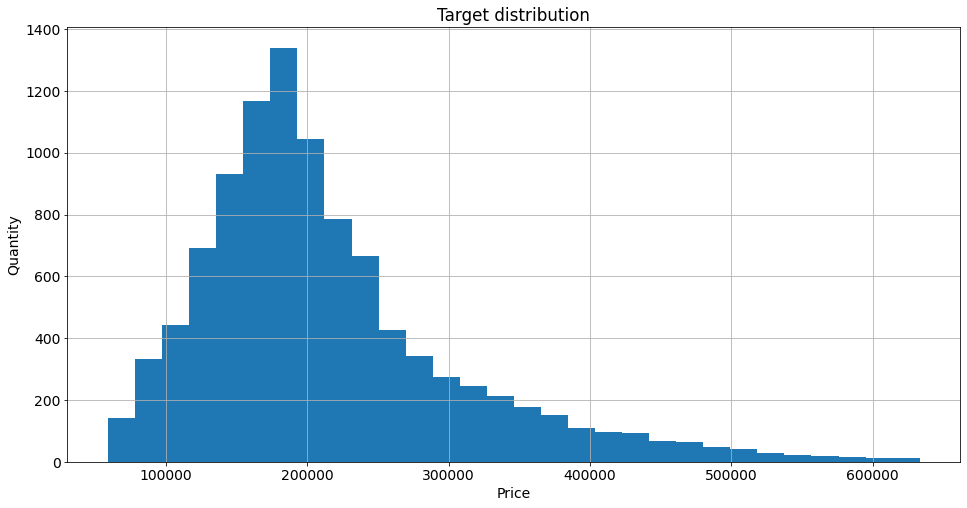

In [8]:
plt.figure(figsize = (16, 8))

train_data['Price'].hist(bins=30)
plt.ylabel('Quantity')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Большее число квартир со средней стоимостью, при этом очень маленькое число квартир с очень большой ценой.

__Количественные переменные__

In [9]:
train_data.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Рассмотрим статистические характеристики признаков.
Есть большой разброс значений с аномальным максимумом (комнаты, площадь, жилая площадь)
Сравним показатели mean и 50%(медиана): если mean больше, значит справа есть хвост больших объектов.

__Нормативные переменные__

In [10]:
list(train_data.select_dtypes(include='object').columns)

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [11]:
train_data['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

##### Обработка выбросов

__HouseYear__

In [12]:
train_data['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1910           1
1916           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

В значениях года постройки есть два выброса. 
Примем, что не может быть дома, построенного позже 2021:

In [13]:
train_data[train_data['HouseYear'] > 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396


In [14]:
current_year = datetime.now().year
train_data['HouseYear_outlier'] = 0
train_data.loc[train_data['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
train_data.loc[train_data['HouseYear'] > current_year, 'HouseYear'] = current_year

In [15]:
train_data[train_data['HouseYear'] > 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier


__Rooms__

In [16]:
train_data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

0 комнат - приравняем к однокоомнатной

более 6 комнат - приравняем к медианным значениям

In [17]:
#обозначим выбросы отдельным признаком
train_data['Rooms_outlier'] = 0 
train_data.loc[(train_data['Rooms'] == 0) | (train_data['Rooms'] > 6), 'Rooms_outlier'] = 1
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.102962,0,0


In [18]:
train_data.loc[train_data['Rooms'] == 0, 'Rooms'] = 1
train_data.loc[train_data['Rooms'] > 6, 'Rooms'] = train_data['Rooms'].median()

In [19]:
train_data['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

__KitchenSquare__

Площадь кухни не может быть больше общей площади квартиры

In [20]:
train_data[train_data['KitchenSquare'] > train_data['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier
2785,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,...,4,915,0,NaN,0,0,B,99079.960518,0,0
5273,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,...,21,5731,0,NaN,1,0,B,160488.033165,0,0
6505,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,...,30,5285,0,645.0,6,6,B,105539.556275,0,0
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,...,2,629,1,NaN,0,0,A,108337.484207,0,0


Вычислим, какую часть площади в среднем занимает кухня:

In [21]:
train_data['Square'].median()

52.51330992401352

In [22]:
train_data['KitchenSquare'].median()

6.0

In [23]:
kitchen_part = train_data['KitchenSquare'].median() / train_data['Square'].median()
kitchen_part

0.11425674764515831

Заменим выбросы:

In [24]:
train_data.loc[train_data['KitchenSquare'] > train_data['Square'], 'KitchenSquare'] = train_data['Square'] * kitchen_part

In [25]:
train_data[train_data['KitchenSquare'] > train_data['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier


__HouseFloor, Floor__

In [26]:
train_data['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [27]:
train_data['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [28]:
(train_data['Floor'] > train_data['HouseFloor']).value_counts()

False    8175
True     1825
dtype: int64

Присутствуют дома с нулевой этажностью, а также 1825 квартир, этаж которых больше, чем этаж дома.

Создадим новый признак, обозначающий строки с выбросами:

In [29]:
train_data['HouseFloor_outlier'] = 0
train_data.loc[train_data['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_data.loc[train_data['Floor'] > train_data['HouseFloor'], 'HouseFloor_outlier'] = 1

Заменим нулевую этажность средними значениями по выборке:

In [30]:
train_data.loc[train_data['HouseFloor'] == 0, 'HouseFloor'] = train_data['HouseFloor'].median()

Для остальных выбросов рандомно определим этажность домов из возможного диапазона этажей, чтобы квартира попадала в этажность дома.

In [31]:
floor_outliers = train_data.loc[train_data['Floor'] > train_data['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [32]:
train_data.loc[floor_outliers, 'Floor'] = train_data.loc[floor_outliers, 'HouseFloor']\
                                .apply(lambda x: random.randint(1, x))

In [33]:
(train_data['Floor'] > train_data['HouseFloor']).value_counts()

False    10000
dtype: int64

##### Обработка пропусков

In [34]:
train_data.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
HouseYear_outlier        0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

Пропуски есть в двух признаках - LifeSquare и Healthcare1

__LifeSquare__

In [35]:
train_data['LifeSquare_nan'] = train_data['LifeSquare'].isna() * 1

Оценим, какую часть площади квартиры без учета кухни составляет жилая площадь 

In [36]:
lifesquare_part = (train_data.loc[~train_data['LifeSquare'].isna(), 'LifeSquare'].median()) / ((train_data.loc[~train_data['LifeSquare'].isna(), 'Square'] - train_data.loc[~train_data['LifeSquare'].isna(), 'KitchenSquare']).median())
lifesquare_part

0.7413825550548533

In [37]:
train_data.loc[train_data['LifeSquare'].isna(), 'LifeSquare'] = (train_data['Square'] - train_data['KitchenSquare']) * lifesquare_part

In [38]:
train_data.loc[train_data['LifeSquare_nan'] == 1].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
0,11809,27,3.0,115.027311,77.865416,10.0,4,10.0,2014,0.075424,...,0,NaN,0,0,B,305018.871089,0,0,0,1
3,2352,1,1.0,40.409907,29.217817,1.0,10,22.0,1977,0.007122,...,0,NaN,0,1,B,168106.007630,0,0,0,1
18,4581,1,1.0,47.582480,34.535438,1.0,16,16.0,1977,0.007122,...,0,NaN,0,1,B,128803.593810,0,0,0,1
20,8768,63,1.0,50.974891,37.050512,1.0,7,16.0,2018,0.238617,...,6,705.0,3,6,B,260328.413376,0,0,0,1
24,4717,27,1.0,44.203947,32.772035,0.0,2,13.0,1977,0.072158,...,1,NaN,0,0,A,135466.559958,0,0,1,1
25,4521,6,2.0,65.409965,47.752425,1.0,1,1.0,1977,0.243205,...,0,540.0,0,0,B,191205.272608,0,0,1,1
30,5931,23,1.0,43.033398,31.162828,1.0,3,4.0,1977,0.014073,...,0,NaN,0,0,B,72659.971575,0,0,0,1
35,3961,23,2.0,65.832954,48.066021,1.0,11,17.0,1977,0.075779,...,3,NaN,0,2,B,193398.613749,0,0,0,1
38,7679,23,2.0,55.521797,41.162892,0.0,3,4.0,1977,0.034656,...,0,NaN,0,0,B,93217.752924,0,0,0,1
44,9024,6,3.0,79.790762,58.414096,1.0,1,1.0,1977,0.243205,...,0,540.0,0,0,B,193595.800511,0,0,1,1


__Healthcare1__

Много пропусков, удалим признак

In [154]:
train_data.drop('Healthcare_1', axis=1, inplace=True)

##### Функция для предобработки данных

In [153]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.current_year=None
        
    def fit(self, df):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = df.median(numeric_only=True)
    
    def transform(self, df):
        """Трансформация данных"""

        # Rooms
        df.insert(len(df.columns), 'Rooms_outlier', 0)
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        kitchen_part = self.medians['KitchenSquare'] / self.medians['Square']
        
        df.loc[df['KitchenSquare'] > df['Square'], 'KitchenSquare'] = df['Square'] * kitchen_part
        
        # HouseFloor, Floor
        df.insert(len(df.columns), 'HouseFloor_outlier', 0)
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        df.insert(len(df.columns), 'HouseYear_outlier', 0)
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        df.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        df.insert(len(df.columns), 'LifeSquare_nan', 0)
        df.loc[df['LifeSquare'].isna(), 'Lifesquare_nan'] = 1
        
        lifesquare_part = (df.loc[~df['LifeSquare'].isna(), 'LifeSquare'].median()) / ((df.loc[~train_data['LifeSquare'].isna(), 'Square'] 
                          - train_data.loc[~train_data['LifeSquare'].isna(), 'KitchenSquare']).median())
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = (df['Square'] - df['KitchenSquare']) * lifesquare_part
        
        
        df.fillna(self.medians, inplace=True)
        
        return df

#### Построение новых признаков

In [43]:
# Переведем буквенную кодировку в численную:
binary_to_numbers = {'A': 0, 'B': 1}

train_data['Ecology_2'] = train_data['Ecology_2'].replace(binary_to_numbers)
train_data['Ecology_3'] = train_data['Ecology_3'].replace(binary_to_numbers)
train_data['Shops_2'] = train_data['Shops_2'].replace(binary_to_numbers)

##### DistrictSize

Переведем признак DistrictId из категориального в вещественный

Для этого создадим новый признак, который будет содержать в себе количество квартир в данном районе

In [44]:
district_size = train_data['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index': 'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [45]:
# добавим в таблицу train_data
train_data = train_data.merge(district_size, on='DistrictId', how='left')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize
0,11809,27,3.0,115.027311,77.865416,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,0,1,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,0,0,652
3,2352,1,1.0,40.409907,29.217817,1.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,0,1,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,0,1,89


In [46]:
(train_data['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [47]:
# создадим признак , который будет проверять, большой ли район (>100 квартир)
train_data['IsDistrictLarge'] = (train_data['DistrictSize'] > 100).astype(int)

##### MedPriceSqmByDistrict

Создадим новый признак - средняя цена за кв метр в районе.

In [48]:
# Рассчитаем цену за кв метр каждой квартиры:
train_data['Price_sqm'] = (train_data['Price']) / (train_data['Square'])
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,HouseYear_outlier,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,Price_sqm
0,11809,27,3.0,115.027311,77.865416,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,0,1,1,851,1,2651.708272
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,0,0,78,0,4462.045990
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,0,0,652,1,3600.596698
3,2352,1,1.0,40.409907,29.217817,1.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,0,1,1,652,1,4160.019670
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,0,1,89,0,5351.088794


In [49]:
# Рассчитаем ср цену за кв м в районах:
sqm_price_by_district = train_data.groupby(['DistrictId'], as_index=False).agg({'Price_sqm': 'median'}).rename(columns={'Price_sqm': 'MedPriceSqmByDistrict'})
sqm_price_by_district.head()

,DistrictId,MedPriceSqmByDistrict
0,0,3935.906409
1,1,3251.647396
2,10,4458.893222
3,100,4933.389994
4,101,4188.414745


In [50]:
# Добавляем признак в таблицу:
train_data = train_data.merge(sqm_price_by_district, on=['DistrictId'], how='left')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,HouseYear_outlier,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,Price_sqm,MedPriceSqmByDistrict
0,11809,27,3.0,115.027311,77.865416,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,0,1,1,851,1,2651.708272,2761.266747
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,0,78,0,4462.045990,3553.678687
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,0,652,1,3600.596698,3251.647396
3,2352,1,1.0,40.409907,29.217817,1.0,10,22.0,1977,0.007122,...,168106.007630,0,0,0,1,1,652,1,4160.019670,3251.647396
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,0,1,89,0,5351.088794,4219.992382


##### MedPriceByFloorYears

Новый признак - ср цена в зависимости от этажа и года постройки

Функции для перевода этажа и года в категории:

In [51]:
def floor_to_cat(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

In [52]:
def year_to_cat(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [53]:
train_data = floor_to_cat(train_data)
train_data = year_to_cat(train_data)
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,Price_sqm,MedPriceSqmByDistrict,floor_cat,year_cat
0,11809,27,3.0,115.027311,77.865416,10.0,4,10.0,2014,0.075424,...,0,0,1,1,851,1,2651.708272,2761.266747,1,5
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,78,0,4462.045990,3553.678687,2,2
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,652,1,3600.596698,3251.647396,0,3
3,2352,1,1.0,40.409907,29.217817,1.0,10,22.0,1977,0.007122,...,0,0,1,1,652,1,4160.019670,3251.647396,3,2
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,1,89,0,5351.088794,4219.992382,4,2


Посчитаем ср стоимость для категорий этажа/года, добавим в таблицу:

In [54]:
med_price_by_floor_year = train_data.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,383900.999360
1,0,1,321497.418777
2,0,2,386374.053775
3,0,3,274992.472366
4,1,0,467230.539057


In [55]:
train_data = train_data.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,Price_sqm,MedPriceSqmByDistrict,floor_cat,year_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,77.865416,10.0,4,10.0,2014,0.075424,...,0,1,1,851,1,2651.708272,2761.266747,1,5,162124.189453
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,78,0,4462.045990,3553.678687,2,2,192358.129020
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,652,1,3600.596698,3251.647396,0,3,205708.069184
3,2352,1,1.0,40.409907,29.217817,1.0,10,22.0,1977,0.007122,...,0,1,1,652,1,4160.019670,3251.647396,3,2,183157.462451
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,1,89,0,5351.088794,4219.992382,4,2,173163.051102


##### Функция генерации новых признаков:

In [177]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.sqm_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['Price_sqm'] = (df['Price']) / (df['Square'])
            
            self.sqm_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price_sqm': 'median'})\
                                            .rename(columns={'Price_sqm': 'MedPriceSqmByDistrict'})
            
            self.sqm_price_by_district_median = self.sqm_price_by_district['MedPriceSqmByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.sqm_price_by_district is not None:
            X = X.merge(self.sqm_price_by_district, on=['DistrictId'], how='left')
            X['MedPriceSqmByDistrict'].fillna(self.sqm_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

#### Отбор признаков

In [57]:
train_data.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseYear_outlier',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'Price_sqm',
 'MedPriceSqmByDistrict',
 'floor_cat',
 'year_cat',
 'MedPriceByFloorYear']

In [295]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 
                     #'Healthcare_1_nan',
                     'DistrictSize', 'IsDistrictLarge',  'MedPriceSqmByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

#### Разбиение на train и test

In [296]:
train_data = pd.read_csv('/Users/daria/code/gb/01/python_libraries/final_project/real-estate-price-prediction-moscow/train.csv')
test_data = pd.read_csv('/Users/daria/code/gb/01/python_libraries/final_project/real-estate-price-prediction-moscow/test.csv')

X = train_data.drop(columns=target_name)
y = train_data[target_name]

In [297]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [298]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

In [299]:
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_data = preprocessor.transform(test_data)

In [300]:
X_train.shape, X_valid.shape, test_data.shape

((6700, 23), (3300, 23), (5000, 23))

In [301]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

In [302]:
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_data = features_gen.transform(test_data)

X_train.shape, X_valid.shape, test_data.shape

((6700, 30), (3300, 30), (5000, 30))

In [303]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_data = test_data[feature_names + new_feature_names]

In [304]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_data.isna().sum().sum()

(0, 0, 0)

In [305]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceSqmByDistrict,MedPriceByFloorYear
0,1.0,43.380798,31.302463,1.0,18,25.0,1977,0.075779,1,1,...,2,1,0,0,0,0,372,1,2292.532478,173934.865013
1,3.0,83.596365,61.005687,1.0,3,16.0,1977,0.000078,1,1,...,23,1,0,0,0,0,148,1,2813.124724,180363.180393
2,2.0,53.610583,31.289235,8.0,10,12.0,1979,0.298205,1,1,...,3,1,0,1,0,0,64,0,4169.261536,180706.641204
3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,1,1,...,2,1,0,0,0,0,44,0,3701.048922,180363.180393
4,1.0,53.810968,39.744789,0.0,4,13.0,1977,0.072158,1,1,...,0,0,0,1,0,0,164,1,2662.904227,188641.370170


#### Построение модели

##### GridSearch for GradientBoosting

С помощью GridSearch побобраны оптимальные параметры:

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 150}

##### Модель GradientBoosting

In [313]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=5,
                                     random_state=42,
                                     n_estimators=150)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=5,
                          n_estimators=150, random_state=42)

Train R2:	0.882
Test R2:	0.753


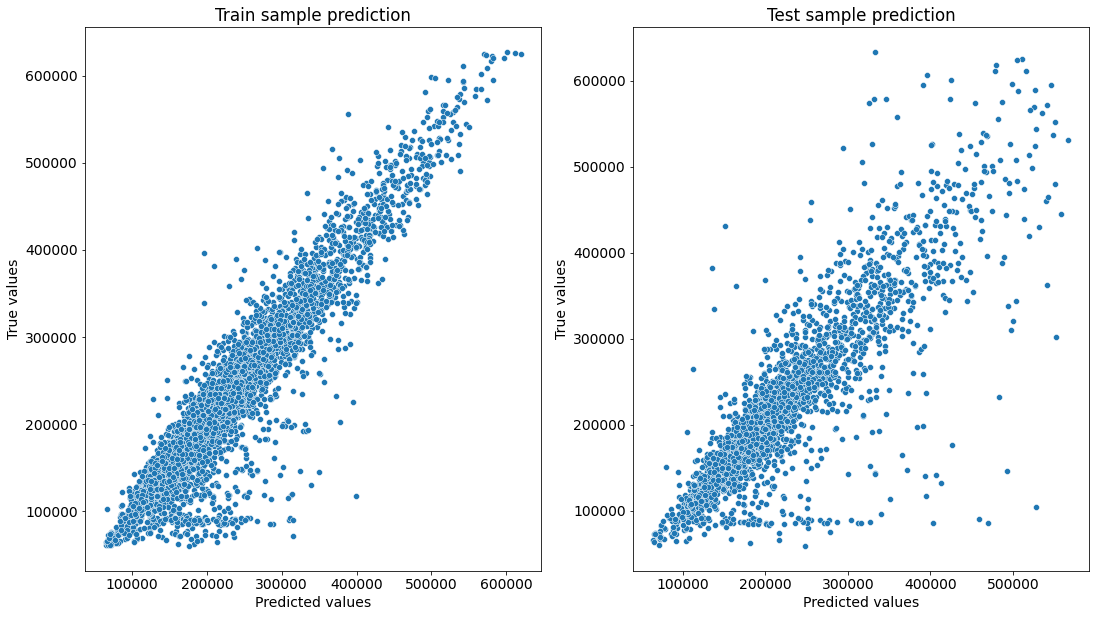

In [314]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [315]:
cv_score_gb = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score_gb.mean()

0.7388442242650819

#### Прогнозирование на тестовом датасете:

In [316]:
test_data.shape

(5000, 24)

In [320]:
submit = pd.read_csv('/Users/daria/code/gb/01/python_libraries/final_project/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [318]:
predictions = gb_model.predict(test_data)
predictions

array([167824.75679846, 124994.09354223, 144993.80349873, ...,
       151274.46289433, 191425.70606961, 250638.19979405])

In [323]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,167824.756798
1,5925,124994.093542
2,960,144993.803499
3,3848,114863.824136
4,746,165858.639393


In [324]:
submit.to_csv('gb_model_submit.csv', index=False)